In [2]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [3]:
data_dir = '../../data/'

In [4]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022_test.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['TA in (mmol/kgSW)'].notnull())]

In [25]:
# Prediction
X = sal_and_ta['SAL (PSU)'].values.reshape(-1, 1)
Y = sal_and_ta['TA in (mmol/kgSW)'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

ValueError: x and y must have same first dimension, but have shapes (469, 1) and (482, 1)

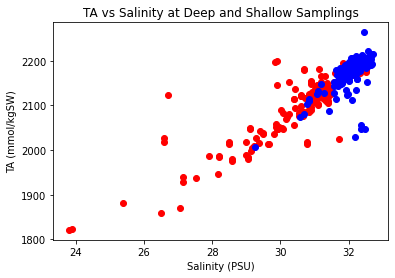

In [26]:
# Deep vs Shallow
shallow = sal_and_ta[sal_and_ta['DEPTH (m)'] < 3]
deep = sal_and_ta[sal_and_ta['DEPTH (m)'] > 19]

plt.scatter(shallow['SAL (PSU)'], shallow['TA in (mmol/kgSW)'], color='red', label='< 3 meters')
plt.scatter(deep['SAL (PSU)'], deep['TA in (mmol/kgSW)'], color='blue', label='> 19 meters')
plt.xlabel('Salinity (PSU)')
plt.ylabel('TA (mmol/kgSW)')
plt.title('TA vs Salinity at Deep and Shallow Samplings')
plt.plot(X, yPlus2R, color = 'red', alpha = 0.2, label = '+ 2 RMSE of Residuals')
plt.plot(X, yMinus2R, color = 'red', alpha = 0.2, label = '- 2 RMSE of Residuals')
plt.plot(X, Y_pred, color='black', label='Prediction')
plt.legend()

In [22]:
# Remove the outliers
sm.add_constant(X)
mlr = sm.OLS(Y, X).fit()
R = float(np.sqrt(mlr.mse_resid))
twoR = 2 * R

yPlus2R = Y_pred + twoR
yMinus2R = Y_pred - twoR

In [24]:
outliers = pd.DataFrame(columns = sal_and_ta.columns)
for ind, row in sal_and_ta.iterrows():
  predicted_ta = float(linear_regressor.predict(np.array(row['SAL (PSU)']).reshape(-1, 1)))
  actual_ta = float(row['TA in (mmol/kgSW)'])
  if abs(predicted_ta - actual_ta) > twoR:
    sal_and_ta.drop(ind, inplace=True) # drop the row with the outlier
    outliers.loc[len(outliers.index)] = row

<ipython-input-24-5e73311d8b1a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_and_ta.drop(ind, inplace=True) # drop the row with the outlier
<ipython-input-24-5e73311d8b1a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_and_ta.drop(ind, inplace=True) # drop the row with the outlier
<ipython-input-24-5e73311d8b1a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_and_ta.drop(ind, inplace=True) # drop the row with the out

In [64]:
outliers.to_csv('outliers.csv')

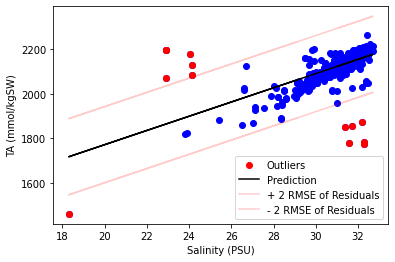

In [15]:
# Plot the non-outliers and the outliers
plt.scatter(sal_and_ta['SAL (PSU)'], sal_and_ta['TA in (mmol/kgSW)'], color='blue')
plt.scatter(outliers['SAL (PSU)'], outliers['TA in (mmol/kgSW)'], color='red', label='Outliers')
plt.plot(X, Y_pred, color='black', label='Prediction')
plt.plot(X, yPlus2R, color = 'red', alpha = 0.2, label = '+ 2 RMSE of Residuals')
plt.plot(X, yMinus2R, color = 'red', alpha = 0.2, label = '- 2 RMSE of Residuals')
plt.xlabel('Salinity (PSU)')
plt.ylabel('TA (mmol/kgSW)')
plt.legend()
plt.show()

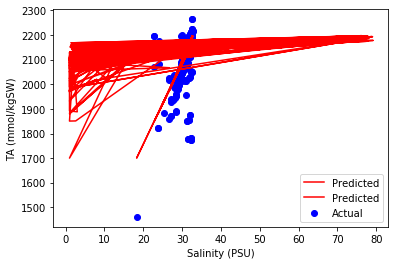

In [60]:
# Use depth and salinity to predict TA
# Create a new dataframe with only the columns we need
sal_and_depth = sal_and_ta[['SAL (PSU)', 'DEPTH (m)']]
sal_and_depth['TA in (mmol/kgSW)'] = Y_pred


X = sal_and_ta[['SAL (PSU)', 'DEPTH (m)']].values
Y = sal_and_ta['TA in (mmol/kgSW)'].values
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

# Plot the data and the regression
plt.scatter(sal_and_ta['SAL (PSU)'], sal_and_ta['TA in (mmol/kgSW)'], color='blue', label='Actual')
plt.plot(X, Y_pred, color='red', label='Predicted')
plt.xlabel('Salinity (PSU)')
plt.ylabel('TA (mmol/kgSW)')
plt.legend()